# Analyse comparative des méthodes de classification {CLAIM} vs. {REF} vs. {CONTEXT} pour les données scientifiques

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.tokenize import TweetTokenizer
import re


from scipy.stats import kruskal

In [5]:
df_path= "../../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

### On filtre seulement les tweets sciences related

In [6]:
df_base = df_base[df_base["science_related"] == 1]
df_base.head()

,text,science_related,scientific_claim,scientific_reference,scientific_context
2,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1,1.0,1.0,1.0
7,Can playing more games improve lives and save ...,1,1.0,0.0,0.0


In [29]:
print(df_base.groupby(["scientific_claim", "scientific_reference", "scientific_context"]).size())

scientific_claim  scientific_reference  scientific_context
0.0               0.0                   1.0                    33
                  1.0                   1.0                    79
1.0               0.0                   0.0                   124
                                        1.0                    15
                  1.0                   1.0                   124
dtype: int64


In [35]:
df = df_base.copy()


df["label_combo"] = df[["scientific_claim", "scientific_reference", "scientific_context"]].astype(int).astype(str).agg(" ".join, axis=1)

label_mapping = {
    '0 0 0': 'NON-SCIENTIFIC',
    '1 0 0': 'CLAIM only',
    '0 1 0': 'REFERENCE only',
    '0 0 1': 'CONTEXT only',
    '1 1 0': 'CLAIM + REFERENCE',
    '1 0 1': 'CLAIM + CONTEXT',
    '0 1 1': 'REFERENCE + CONTEXT',
    '1 1 1': 'CLAIM + REFERENCE + CONTEXT',
}

df['classe'] = df['label_combo'].map(label_mapping)


df.drop(["label_combo", "science_related", "scientific_claim", "scientific_reference", "scientific_context"], axis=1, inplace=True)
df.head(10)


,text,classe
2,Can any Gynecologist with Cancer Experience ex...,CLAIM only
3,Couch-lock highs lead to sleeping in the couch...,CLAIM only
4,Does daily routine help prevent problems with ...,CLAIM only
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,CLAIM + REFERENCE + CONTEXT
7,Can playing more games improve lives and save ...,CLAIM only
8,The effect of climate change on iceberg produc...,REFERENCE + CONTEXT
14,@RepCohen @SenAlexander @SenBobCorker pls supp...,CONTEXT only
15,Poverty is the greatest cause behind child lab...,CLAIM only
16,"""@TheFactsBook: Drinking chocolate milk has be...",CLAIM only
24,"A wise Physician said, “The best medicine for ...",CLAIM only


# Analyse général de la structure du dataset

In [36]:

# Display basic information about the dataset
print(f"Dataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nDataset information:\n")
print(df.info())

print("\nSummary statistics:")
display(df.describe())

Dataset dimensions: 375 rows, 2 columns

Dataset information:

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 2 to 1135
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    375 non-null    string
 1   classe  375 non-null    object
dtypes: object(1), string(1)
memory usage: 8.8+ KB
None

Summary statistics:


,text,classe
count,375,375
unique,374,5
top,"The happier you are, the less sleep you requir...",CLAIM only
freq,2,124


- On comprends déja qu'il y a 375 tweets, ce qui est tres peux pour 7 classes (si on gère le chevauchement) et tres peux pour 3 classes aussi (claim vs context vs ref)
- il n'y as pas de missing values (d'après le dataset information).

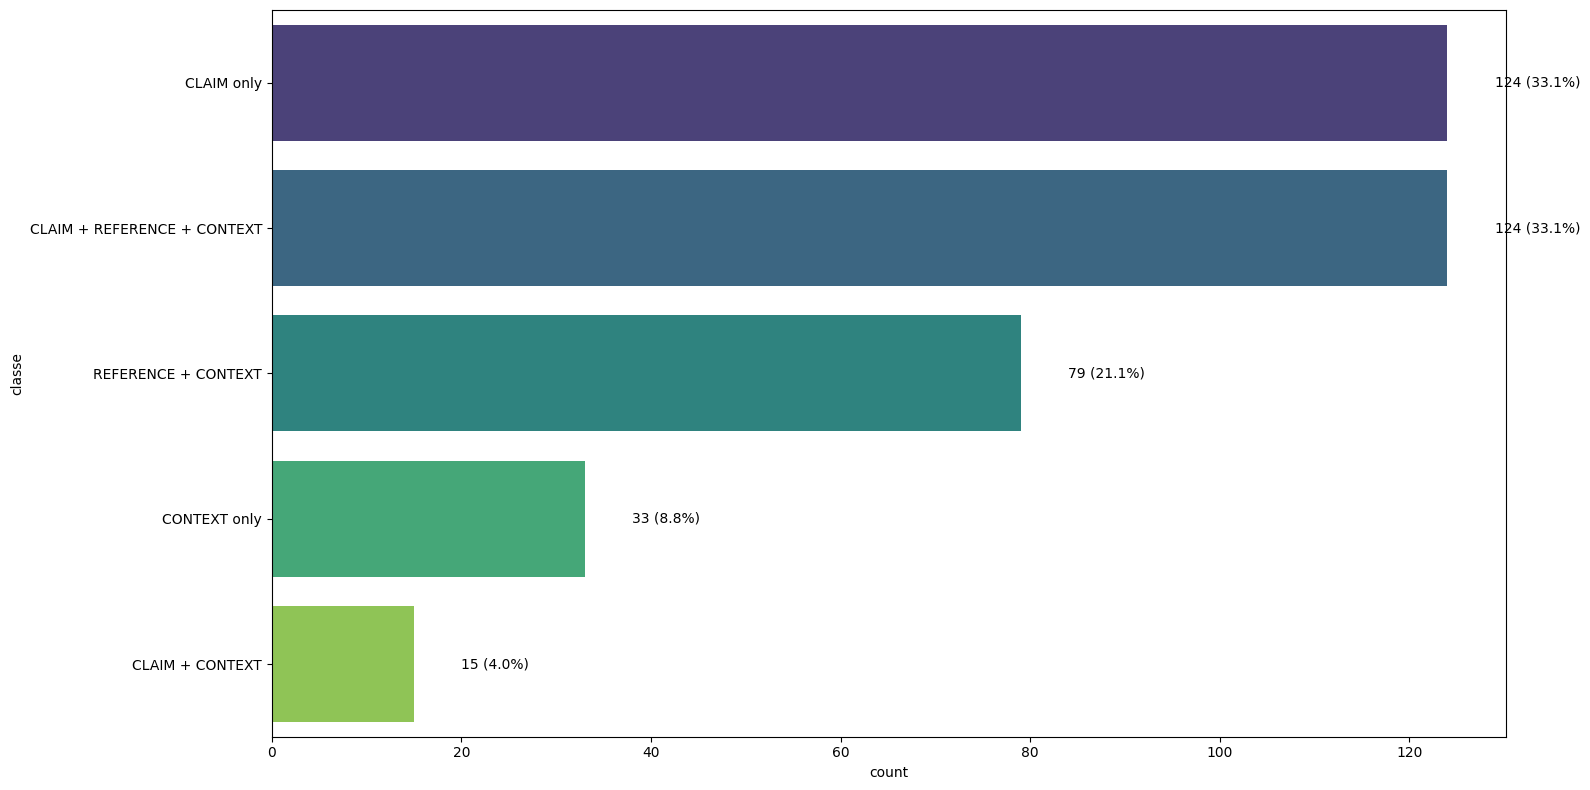

In [43]:
plt.figure(figsize=(16, 8))

counts = df['classe'].value_counts()
ax = sns.countplot(y='classe', data=df, order=counts.index, palette='viridis')
for i, count in enumerate(counts.values):
	percentage = (count / len(df)) * 100
	ax.text(count + 5, i, f"{count} ({percentage:.1f}%)", va='center')

plt.tight_layout()
plt.show()

# Analyse des patterns linguistiques et structurels

In [56]:
def visible_label():
	plt.xticks(ticks=range(len(df['classe'].unique())), labels=df['classe'].unique(), rotation=15, ha="right", fontsize=6)

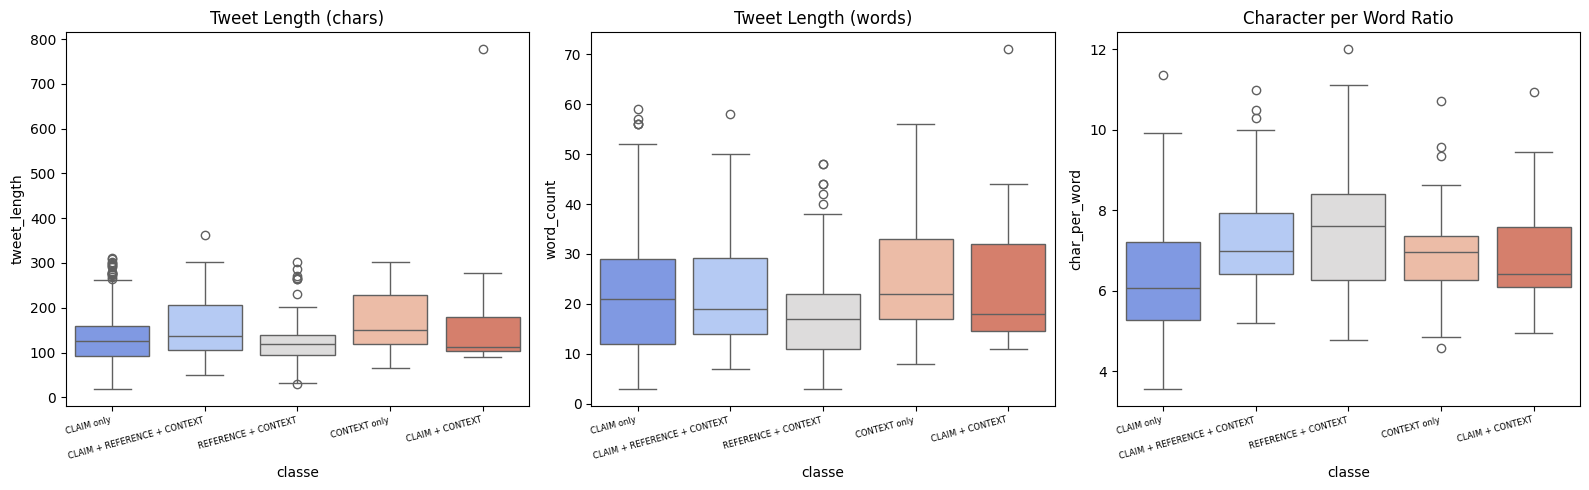

In [57]:
tokenizer = TweetTokenizer()

# Longueur en caractères
df["tweet_length"] = df["text"].apply(len)
# Nombre de mots
df["word_count"] = df["text"].apply(lambda x: len(tokenizer.tokenize(x)))
# Ratio caractères / mots
df["char_per_word"] = df["tweet_length"] / df["word_count"]

both_tweets = df[df["classe"] == 2]["tweet_length"]
context_tweets = df[df["classe"] == 1]["tweet_length"]
claim_ref_tweets = df[df["classe"] == 0]["tweet_length"]

plt.figure(figsize=(16, 5))

# 1. Longueur (caractères)
plt.subplot(1, 3, 1)
sns.boxplot(x="classe", y="tweet_length", data=df, palette="coolwarm")
visible_label()
plt.title("Tweet Length (chars)")
# 2. Nombre de mots
plt.subplot(1, 3, 2)
sns.boxplot(x="classe", y="word_count", data=df, palette="coolwarm")
visible_label()
plt.title("Tweet Length (words)")
# 3. Ratio char/mot
plt.subplot(1, 3, 3)
sns.boxplot(x="classe", y="char_per_word", data=df, palette="coolwarm")
visible_label()
plt.title("Character per Word Ratio")

plt.tight_layout()
plt.show()

Je me suis rendu compte que le ratio de lettre par mot peut être discriminants pour séparer claim ref de context / both

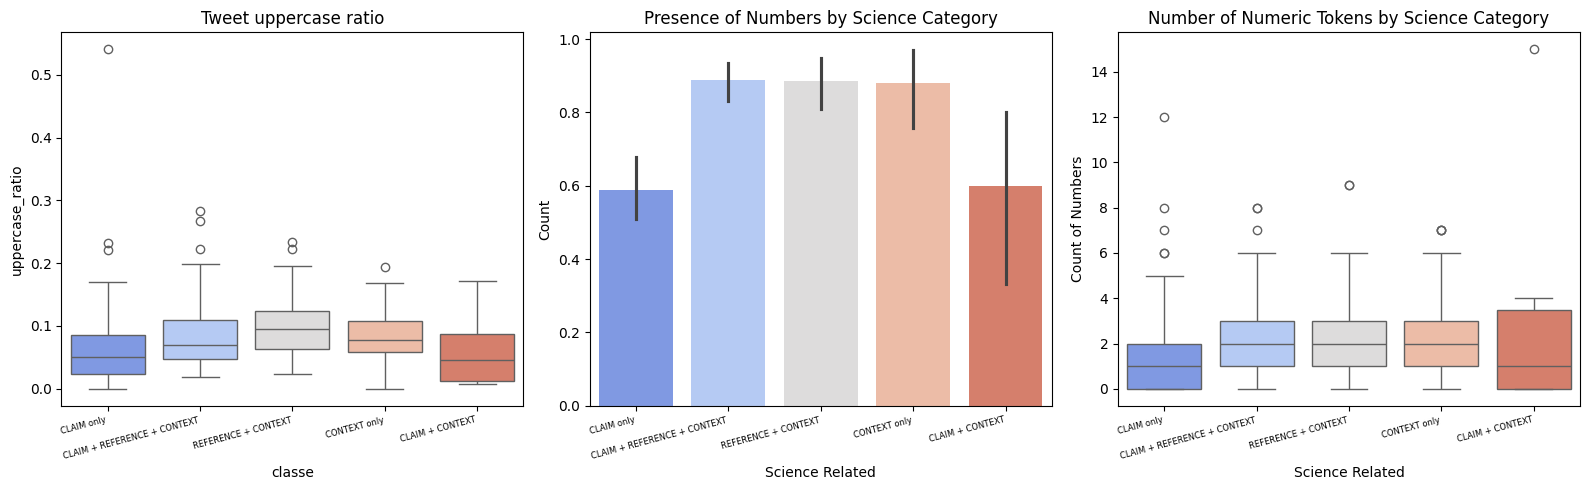

In [58]:
df["uppercase_ratio"] = df["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df["contains_numbers"] = df["text"].apply(lambda x: 1 if re.search(r'\d+', x) else 0)
df["numbers_count"] = df["text"].apply(lambda x: len(re.findall(r'\d+', x)))

plt.figure(figsize=(16, 5))

# 1. Ratio majuscule
plt.subplot(1, 3, 1)
sns.boxplot(x="classe", y="uppercase_ratio", data=df, palette="coolwarm")
plt.title("Tweet uppercase ratio")
visible_label()

# 2. contient des nombres
plt.subplot(1, 3, 2)
sns.barplot(x="classe", y="contains_numbers", data=df, palette="coolwarm")
plt.title("Presence of Numbers by Science Category")
plt.xlabel("Science Related")
plt.ylabel("Count")
visible_label()

plt.subplot(1, 3, 3)
sns.boxplot(x="classe", y="numbers_count", data=df, palette="coolwarm")
plt.title("Number of Numeric Tokens by Science Category")
plt.xlabel("Science Related")
plt.ylabel("Count of Numbers")
visible_label()
plt.tight_layout()

plt.show()

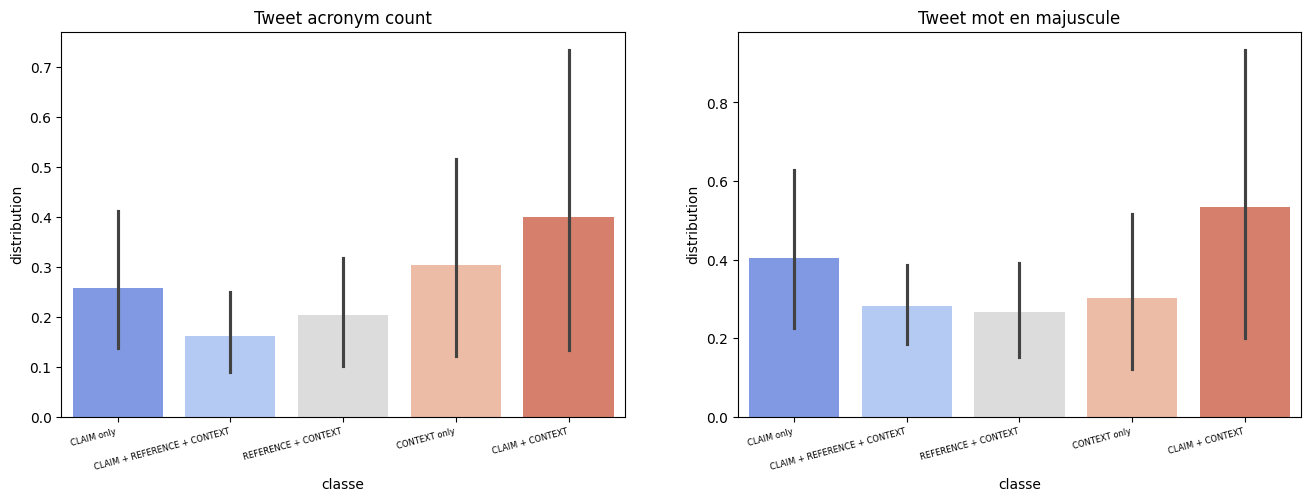

In [59]:
def count_acronyms(text):
    words = text.split()
    return sum(1 for word in words if word.isupper() and 2 <= len(word) <= 5 and word.isalpha())

def count_all_uppercase_words(text):
    words = text.split()
    return sum(1 for word in words if word.isupper() and word.isalpha())

df["acronym_count"] = df["text"].apply(count_acronyms)
df["all_uppercase_words"] = df["text"].apply(count_all_uppercase_words)

plt.figure(figsize=(16, 5))


plt.subplot(1, 2, 1)
sns.barplot(x="classe", y="acronym_count", data=df, palette="coolwarm")
plt.title("Tweet acronym count")
plt.ylabel("distribution")
visible_label()

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="all_uppercase_words", data=df, palette="coolwarm")
plt.ylabel("distribution")
plt.title("Tweet mot en majuscule")
visible_label()

plt.show()

la corrélation entre est est de 0.37 ce qui veut dire qu'ils sont pas totalement indépendants, mais pas redondants non plus.
Je pense que la feature acronym_count ne sera pas utile...

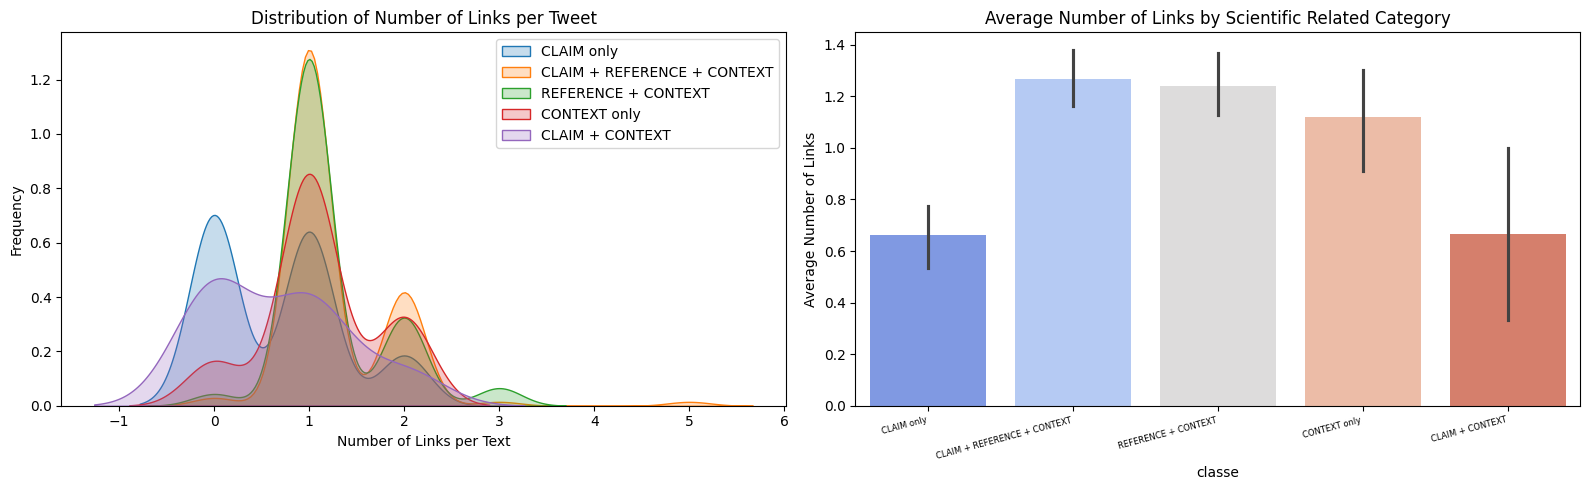

In [61]:
def count_links(text):
    """Counts the number of URLs in a text."""
    url_pattern = r'https?://\S+|www\.\S+'
    return len(re.findall(url_pattern, str(text)))

df["num_links"] = df["text"].apply(count_links)
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
for name in df["classe"].unique():
    sns.kdeplot(df[df["classe"] == name]["num_links"], label=name, shade=True)
plt.legend()
plt.xlabel("Number of Links per Text")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Links per Tweet")

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="num_links", data=df, palette="coolwarm")
plt.title("Average Number of Links by Scientific Related Category")
plt.ylabel("Average Number of Links")
visible_label()

plt.tight_layout()
plt.show()


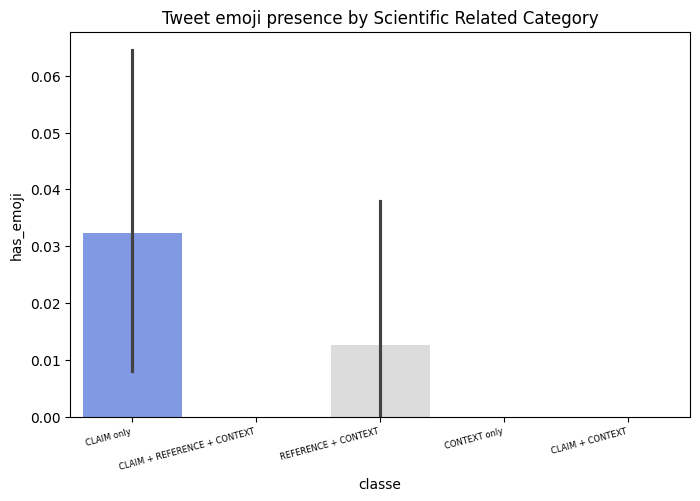

In [85]:
import emoji 
	
def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)

def has_emoji(text):
    """Detects if a text contains at least one emoji."""
    return any(char in emoji.EMOJI_DATA for char in text)


df["has_emoji"] = df["text"].apply(has_emoji)
df["count_emoji"] = df["text"].apply(count_emojis)

plt.figure(figsize=(8  , 5))

sns.barplot(x="classe", y="has_emoji", data=df, palette="coolwarm")
plt.title("Tweet emoji presence by Scientific Related Category")
visible_label()

plt.show()

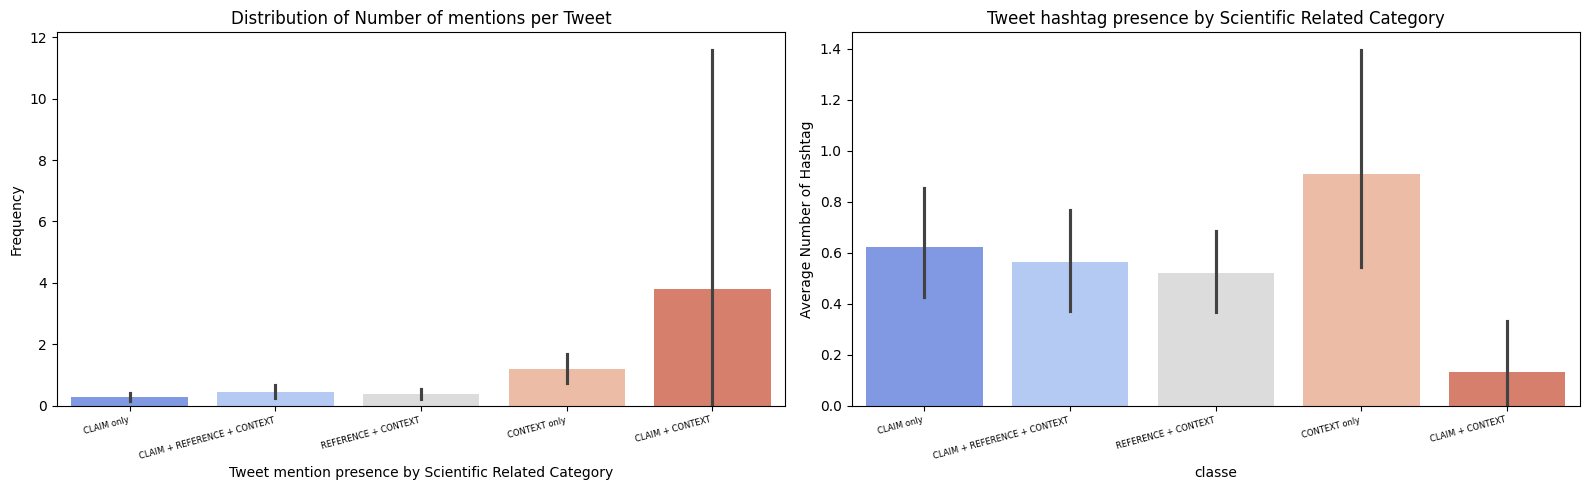

In [65]:
def mentions_number(text):
	"""Compute the number of tags by text ."""
	return len(re.findall(r'@[A-Za-z0-9_]+', text))

def hashtags_number(text):
	"""Compute the number of hashtags in the text."""
	return len(re.findall(r'#[A-Za-z0-9_]+', text))

df["mentions_number"] = df["text"].apply(mentions_number)
df["hashtags_number"] = df["text"].apply(hashtags_number)


plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x="classe", y="mentions_number", data=df, palette="coolwarm")
plt.xlabel("Tweet mention presence by Scientific Related Category")
plt.ylabel("Frequency")
visible_label()
plt.title("Distribution of Number of mentions per Tweet")

plt.subplot(1, 2, 2)
sns.barplot(x="classe", y="hashtags_number", data=df, palette="coolwarm")
plt.title("Tweet hashtag presence by Scientific Related Category")
visible_label()
plt.ylabel("Average Number of Hashtag")

plt.tight_layout()
plt.show()

# Hastag

<Figure size 1400x1000 with 0 Axes>

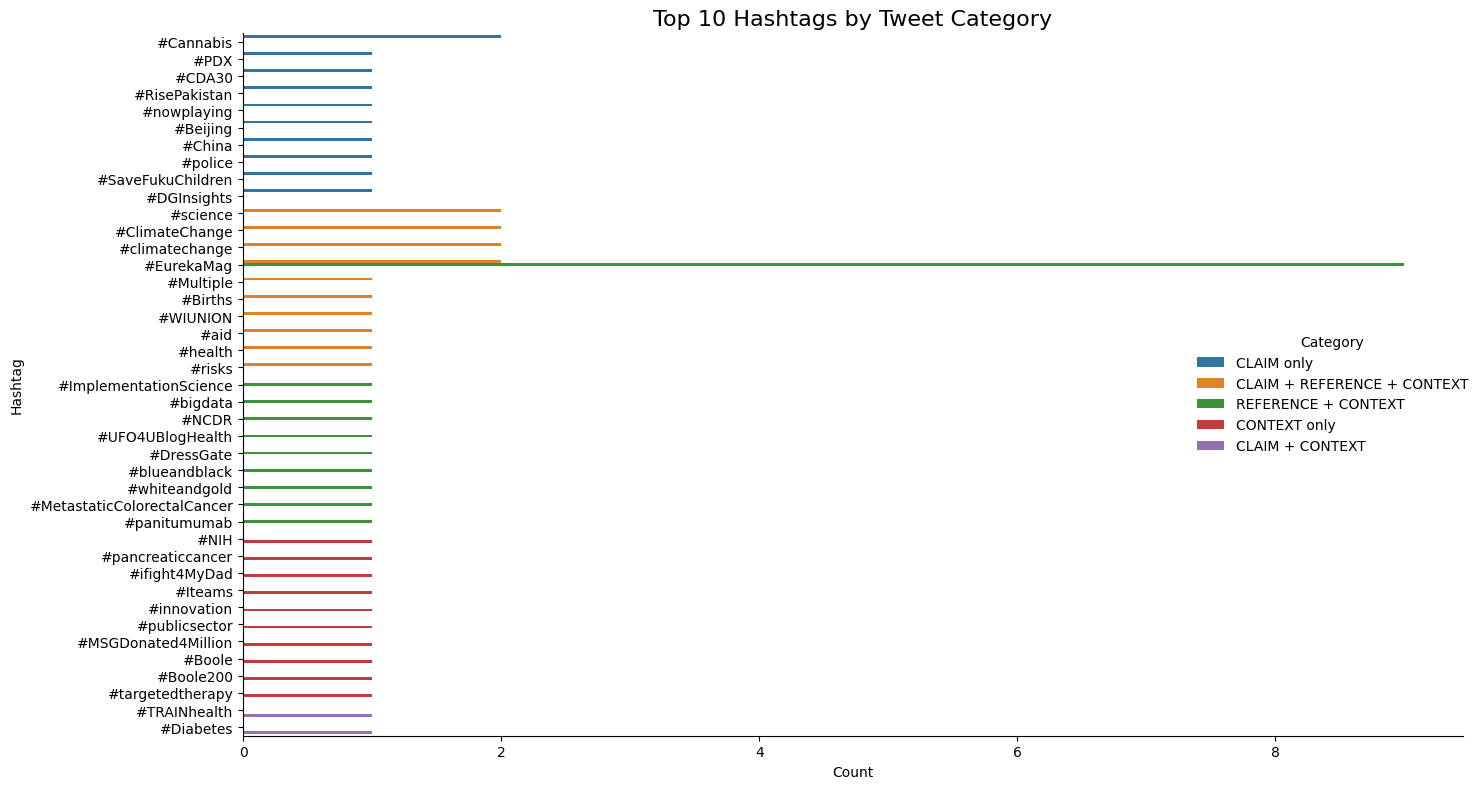

In [ ]:
def hashtags(text):
	"""Extract hashtags from text."""
	return re.findall(r'#[A-Za-z0-9_]+', text)

df_list = []

for class_name in df["classe"].unique():
    subset = df[df["classe"] == class_name]
    all_words = []

    for text in subset["text"]:
        all_words.extend(hashtags(text))

    word_counts = Counter(all_words).most_common(10)
    class_df = pd.DataFrame(word_counts, columns=["Hashtag", "Count"])
    class_df["Category"] = class_name

    df_list.append(class_df)

# Combine tout dans un seul DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Tracer
plt.figure(figsize=(14, 10))
sns.catplot(
    data=combined_df,
    kind="bar",
    x="Count", y="Hashtag", hue="Category",
    height=8, aspect=1.5
)

plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.title("Top 10 Hashtags by Tweet Category", fontsize=16)
plt.tight_layout()
plt.show()

Je sais pas pourquoi je continue a faire ça...
C'est pas utile a cause du nombre rarisime

## Recherche de ces termes utiliser, en dehors d'un hastag

[nltk_data] Downloading package punkt to
[nltk_data]     /home/allan_dwyre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/allan_dwyre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 1400x1000 with 0 Axes>

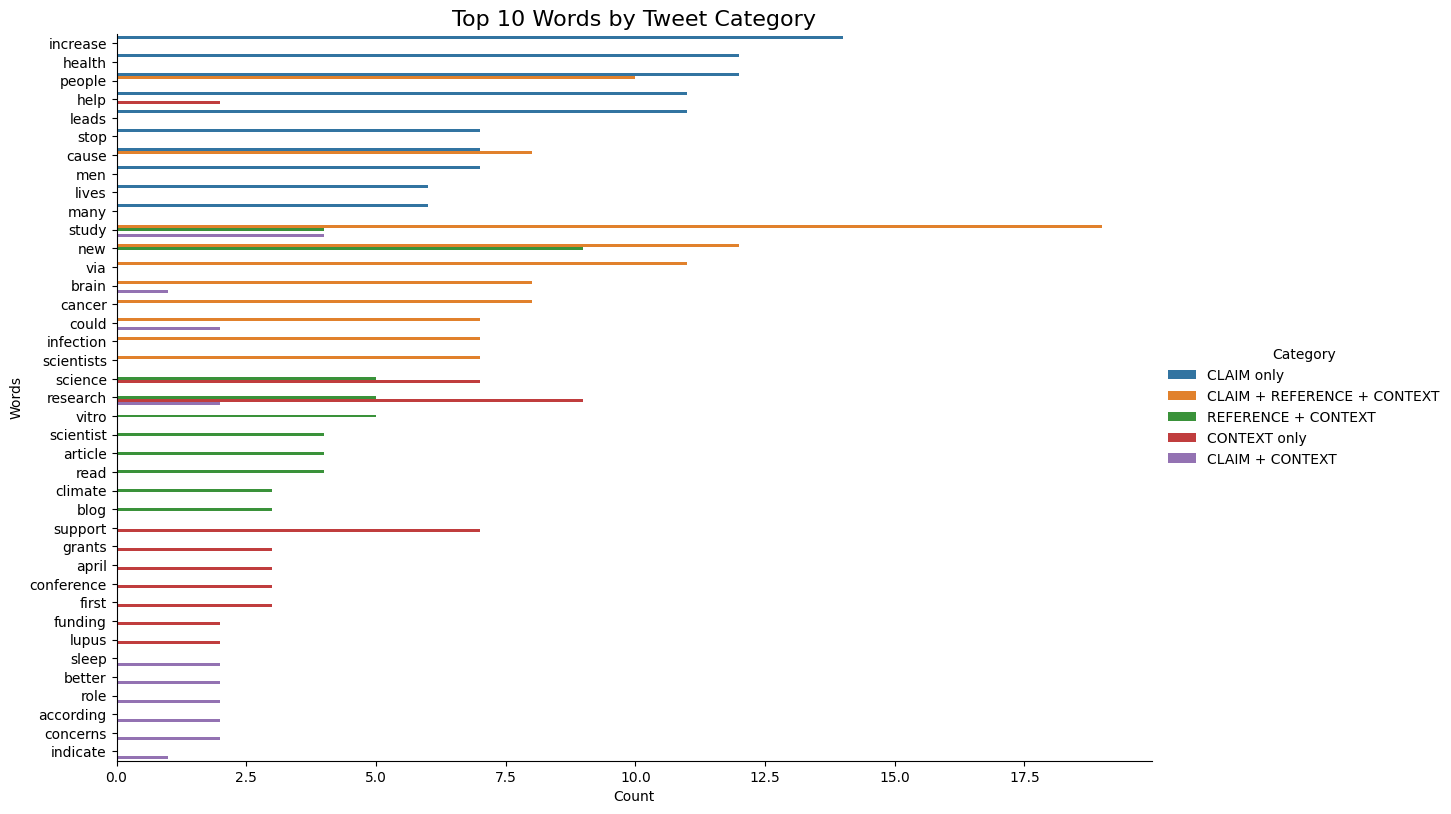

In [91]:
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Supprime les hashtags
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Supprime les liens
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    return words

df_list = []

for class_name in df["classe"].unique():
    subset = df[df["classe"] == class_name]
    all_words = []

    for text in subset["text"]:
        all_words.extend(clean_text(text))

    word_counts = Counter(all_words).most_common(10)
    class_df = pd.DataFrame(word_counts, columns=["Words", "Count"])
    class_df["Category"] = class_name

    df_list.append(class_df)

# Combine tout dans un seul DataFrame
combined_df = pd.concat(df_list, ignore_index=True)


plt.figure(figsize=(14, 10))
sns.catplot(
    data=combined_df, 
    kind="bar",
    x="Count", y="Words", hue="Category",
    height=8, aspect=1.5
)

plt.xlabel("Count")
plt.ylabel("Words")
plt.title('Top 10 Words by Tweet Category', fontsize=16)
plt.show()

# Conclusion de l'analyse des classes : 